## Simple DNN to mimic StIC inversions 

In [1]:
# Initial imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary #https://github.com/sksq96/pytorch-summary
torch.manual_seed(1234)
np.random.seed(1234)
from torch.utils.data import Subset

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# We are going to make a dense autoencoder here:


class testdnn(nn.Module):
    def __init__(self, inputsize, outputsize):
        super(testdnn, self).__init__()
        self.linear1 = nn.Linear(inputsize,64)
        self.linear1a = nn.Linear(64,64)
        self.linear2 = nn.Linear(64,32)
        self.linear2a = nn.Linear(32,32)
        self.linear3 = nn.Linear(32,24)
        self.linear4 = nn.Linear(24,24)
        self.linear5 = nn.Linear(24,24)
        self.linear6 = nn.Linear(24,outputsize)
        
        
        self.activation = nn.ReLU()
        self.activationS = nn.Sigmoid()
        
        
        self.dropout05 = nn.Dropout(0.5)
        
        
    def forward(self, data_in):
        
        x = self.linear1(data_in)
        x = self.activationS(x)
        x = self.linear1a(x)
        x = self.activationS(x)
        x = self.linear2(x)
        x = self.activationS(x)
        x = self.linear2a(x)
        x = self.activationS(x)
        x = self.linear3(x)
        x = self.activationS(x)
        x = self.linear4(x)
        x = self.activationS(x)
        x = self.linear5(x)
        x = self.activationS(x)
        data_out = self.linear6(x)
        #data_out = self.activationS(x)
            
        return data_out
    
def make_model(cudaoption, inputsize, outputsize):
    
    model = testdnn(inputsize, outputsize)
    
    if (cudaoption):
        print('[INFO] Cuda model:',torch.cuda.get_device_name(0))
        model = model.to(device)
        
        print('[INFO] Parameters in GPU:',next(model.parameters()).is_cuda) 
        
    return model   

def model_predict(model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.forward(inputdata)
    
    output = output.to("cpu")
    return output

## Let's make a function to train:

def compilefit(model, data_in, data_out, data_val_in, data_val_out, nepochs, criterion, cudaoption, lri, output_interval, batch, weight_decayi, w):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lri, weight_decay = weight_decayi)
    loss_fn = nn.MSELoss()
    loss_val_fn = nn.MSELoss()
    
    if cudaoption:
        data_in = data_in.to(device)
        data_out = data_out.to(device)
        data_val_in = data_val_in.to(device)
        data_val_out = data_val_out.to(device)
        
        w = w.to(device)
        
        
    performance = np.zeros([2,nepochs])
                
    for i in range(0,nepochs):
            
        optimizer.zero_grad()
        out = model.forward(data_in)
        loss = loss_fn(data_out, out)
        loss.backward()
        optimizer.step()
        performance[0,i] = loss.item()
        
        # Validation:
        out_val = model.forward(data_val_in)
        loss_val = loss_val_fn(out_val, data_val_out)
        performance[1,i] = loss_val.item()
        
            
        if (i+1)%int(output_interval)==0: print(f' It : {i+1:3d} - residual std : {np.sqrt(loss.item()):.6f} - val std : {np.sqrt(loss_val.item()):.6f}')
    return performance

In [3]:
# test for GPU:

cudaoption = torch.cuda.is_available()
device = torch.device("cuda:0" if cudaoption else "cpu")
print('[INFO] Cuda:', cudaoption)
print('[INFO] Cuda device:', device)

[INFO] Cuda: True
[INFO] Cuda device: cuda:0


In [4]:
dnn_model = make_model(cudaoption, 97, 18)

[INFO] Cuda model: NVIDIA GeForce RTX 2060 with Max-Q Design
[INFO] Parameters in GPU: True


### Ok, creating the model and making sure GPU works is done, now let's see what happens with data.

In [5]:
from astropy.io import fits 
import numpy as np
import sparsetools as sp
import imtools as im #in the STiC example folder
import matplotlib.pyplot as plt 

In [6]:
data_out = fits.open("full_training_set_out.fits")
data_out.info()

Filename: full_training_set_out.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (8, 680, 350)   float64   
  1                1 ImageHDU         8   (5, 680, 350)   float64   
  2                1 ImageHDU         8   (5, 680, 350)   float64   


In [7]:
data_in = fits.open("full_training_set_in.fits")

In [8]:
stokes = data_in[0].data
stokes.shape

(350, 680, 97, 4)

In [9]:
data_in = stokes[:,:,:,0]
data_in = data_in.reshape(350*680, 97)

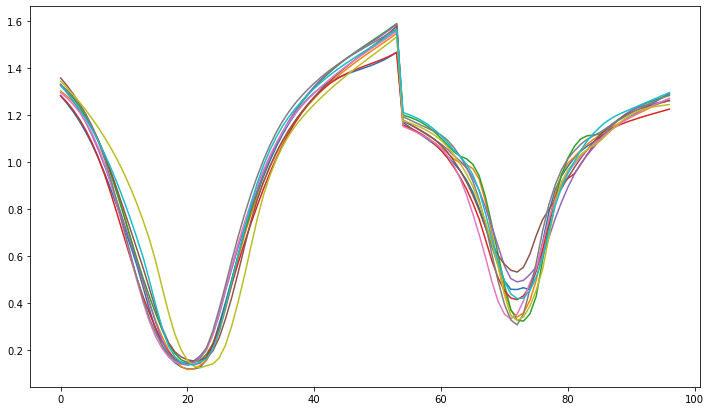

In [10]:
plt.figure(figsize=[12,7])
for i in range(0,10):
    plt.plot(data_in[i*10000])

In [11]:
# This looks nicely normalized but we can normalize it further:

In [12]:
data_in_norm = np.copy(data_in)

In [13]:
# Let's try with a normalization w.r.t. line core:
mean_spectrum = np.mean(data_in_norm,axis=(0))
w = np.sqrt(mean_spectrum)
w = torch.from_numpy(w.astype('float32'))

In [14]:
dimax = np.amax(data_in_norm)
dimin = np.amin(data_in_norm)

In [15]:
data_in_norm[:,:] = (data_in_norm[:,:] - dimin) / (dimax - dimin)

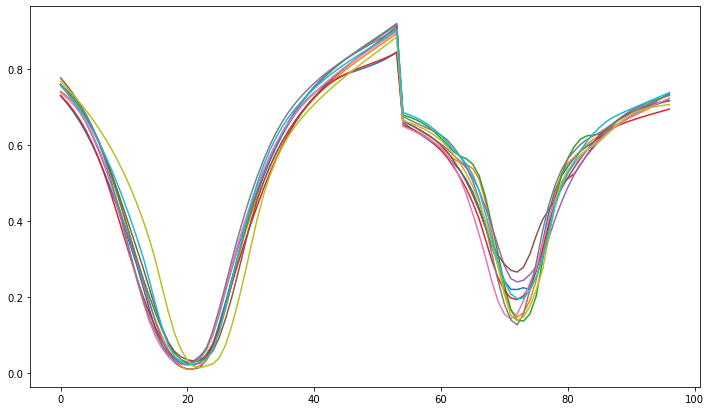

In [16]:
plt.figure(figsize=[12,7])
for i in range(0,10):
    plt.plot(data_in_norm[i*10000])

In [17]:
data_in_norm = torch.from_numpy(data_in_norm.astype('float32'))

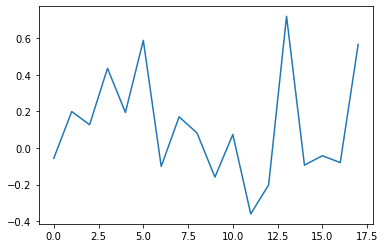

In [18]:
test_output = model_predict(dnn_model,data_in_norm[:10],cudaoption)
test_output.shape
plt.plot(test_output[0].detach().numpy())

### Normalize the output data:

In [19]:
data_out = fits.open("full_training_set_out.fits")

In [20]:
temp = data_out[0].data
vlos = data_out[1].data
vturb = data_out[2].data

# Normalizations:
max_t = np.amax(temp)
min_t = np.amin(temp)
max_vlos = np.amax(vlos)
min_vlos = np.amin(vlos)
max_vturb = np.amax(vturb)
min_vturb = np.amin(vturb)


In [21]:
print(min_t,max_t)
print(min_vlos/1E5, max_vlos/1E5)
print(min_vturb/1E5, max_vturb/1E5)

3100.0 8384.9228515625
-150.0 9.654274375
0.0 15.0


In [22]:
min_vlos = -10.*1E5

In [23]:
temp_norm = (temp-min_t) / (max_t - min_t)
vlos_norm = (vlos-min_vlos) / (max_vlos - min_vlos)
vturb_norm = (vturb-min_vturb) / (max_vturb - min_vturb)

In [24]:
data_out_norm = np.concatenate((temp_norm, vlos_norm, vturb_norm),axis=2)
data_out_norm = data_out_norm.reshape(350*680, 18)
data_out_norm.shape

(238000, 18)

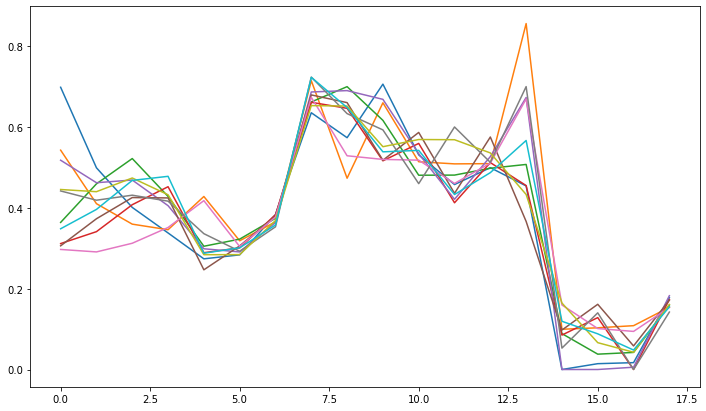

In [25]:
plt.figure(figsize=[12,7])
for i in range(0,10):
    plt.plot(data_out_norm[i*100])

In [45]:
data_out_norm = torch.from_numpy(data_out_norm.astype('float32'))

In [46]:
convergence = compilefit(dnn_model, data_in_norm, data_out_norm, data_in_norm, data_out_norm, \
                         500000, 0, cudaoption, 2E-3, 500, 128, 0, w)

 It : 500 - residual std : 0.033957 - val std : 0.033122
 It : 1000 - residual std : 0.032958 - val std : 0.033099
 It : 1500 - residual std : 0.033293 - val std : 0.033167
 It : 2000 - residual std : 0.033877 - val std : 0.034050
 It : 2500 - residual std : 0.033114 - val std : 0.032930
 It : 3000 - residual std : 0.033041 - val std : 0.033100
 It : 3500 - residual std : 0.032895 - val std : 0.033087
 It : 4000 - residual std : 0.033014 - val std : 0.033205
 It : 4500 - residual std : 0.035047 - val std : 0.034687
 It : 5000 - residual std : 0.033062 - val std : 0.033195
 It : 5500 - residual std : 0.033391 - val std : 0.033750
 It : 6000 - residual std : 0.032823 - val std : 0.032875
 It : 6500 - residual std : 0.032784 - val std : 0.032865
 It : 7000 - residual std : 0.033388 - val std : 0.033260
 It : 7500 - residual std : 0.032794 - val std : 0.032818
 It : 8000 - residual std : 0.033009 - val std : 0.032976
 It : 8500 - residual std : 0.033361 - val std : 0.033184
 It : 9000 - re

 It : 70500 - residual std : 0.032445 - val std : 0.032561
 It : 71000 - residual std : 0.032778 - val std : 0.032576
 It : 71500 - residual std : 0.033095 - val std : 0.033147
 It : 72000 - residual std : 0.032483 - val std : 0.032502
 It : 72500 - residual std : 0.032686 - val std : 0.032683
 It : 73000 - residual std : 0.032535 - val std : 0.032508
 It : 73500 - residual std : 0.032838 - val std : 0.032702
 It : 74000 - residual std : 0.032351 - val std : 0.032375
 It : 74500 - residual std : 0.032527 - val std : 0.032558
 It : 75000 - residual std : 0.032285 - val std : 0.032263
 It : 75500 - residual std : 0.032264 - val std : 0.032286
 It : 76000 - residual std : 0.032146 - val std : 0.032279
 It : 76500 - residual std : 0.032914 - val std : 0.032490
 It : 77000 - residual std : 0.032352 - val std : 0.032266
 It : 77500 - residual std : 0.032645 - val std : 0.032707
 It : 78000 - residual std : 0.034803 - val std : 0.033820
 It : 78500 - residual std : 0.033108 - val std : 0.0330

 It : 139500 - residual std : 0.031996 - val std : 0.032151
 It : 140000 - residual std : 0.031658 - val std : 0.031684
 It : 140500 - residual std : 0.031577 - val std : 0.031608
 It : 141000 - residual std : 0.031811 - val std : 0.031765
 It : 141500 - residual std : 0.032027 - val std : 0.031987
 It : 142000 - residual std : 0.031749 - val std : 0.031753
 It : 142500 - residual std : 0.031718 - val std : 0.031686
 It : 143000 - residual std : 0.031572 - val std : 0.031581
 It : 143500 - residual std : 0.031877 - val std : 0.031818
 It : 144000 - residual std : 0.031853 - val std : 0.031999
 It : 144500 - residual std : 0.032424 - val std : 0.031971
 It : 145000 - residual std : 0.032119 - val std : 0.032258
 It : 145500 - residual std : 0.031753 - val std : 0.031809
 It : 146000 - residual std : 0.031672 - val std : 0.031638
 It : 146500 - residual std : 0.031695 - val std : 0.031766
 It : 147000 - residual std : 0.031910 - val std : 0.032004
 It : 147500 - residual std : 0.031497 -

 It : 208000 - residual std : 0.030999 - val std : 0.031001
 It : 208500 - residual std : 0.031639 - val std : 0.031407
 It : 209000 - residual std : 0.031715 - val std : 0.031350
 It : 209500 - residual std : 0.031053 - val std : 0.031011
 It : 210000 - residual std : 0.030998 - val std : 0.031040
 It : 210500 - residual std : 0.031064 - val std : 0.031104
 It : 211000 - residual std : 0.031280 - val std : 0.031215
 It : 211500 - residual std : 0.031042 - val std : 0.031120
 It : 212000 - residual std : 0.031249 - val std : 0.031156
 It : 212500 - residual std : 0.031697 - val std : 0.031634
 It : 213000 - residual std : 0.031128 - val std : 0.031165
 It : 213500 - residual std : 0.031024 - val std : 0.031072
 It : 214000 - residual std : 0.030909 - val std : 0.030911
 It : 214500 - residual std : 0.031067 - val std : 0.031160
 It : 215000 - residual std : 0.031062 - val std : 0.031016
 It : 215500 - residual std : 0.031273 - val std : 0.031106
 It : 216000 - residual std : 0.031462 -

 It : 276500 - residual std : 0.030559 - val std : 0.030471
 It : 277000 - residual std : 0.031036 - val std : 0.030865
 It : 277500 - residual std : 0.030430 - val std : 0.030413
 It : 278000 - residual std : 0.030613 - val std : 0.030652
 It : 278500 - residual std : 0.030596 - val std : 0.030702
 It : 279000 - residual std : 0.030515 - val std : 0.030541
 It : 279500 - residual std : 0.030507 - val std : 0.030547
 It : 280000 - residual std : 0.030721 - val std : 0.030719
 It : 280500 - residual std : 0.030711 - val std : 0.030587
 It : 281000 - residual std : 0.031146 - val std : 0.031079
 It : 281500 - residual std : 0.030595 - val std : 0.030610
 It : 282000 - residual std : 0.030376 - val std : 0.030443
 It : 282500 - residual std : 0.030527 - val std : 0.030553
 It : 283000 - residual std : 0.030619 - val std : 0.030555
 It : 283500 - residual std : 0.030570 - val std : 0.030724
 It : 284000 - residual std : 0.031095 - val std : 0.031101
 It : 284500 - residual std : 0.030431 -

 It : 345000 - residual std : 0.030191 - val std : 0.030167
 It : 345500 - residual std : 0.030269 - val std : 0.030218
 It : 346000 - residual std : 0.030415 - val std : 0.030299
 It : 346500 - residual std : 0.030339 - val std : 0.030338
 It : 347000 - residual std : 0.029917 - val std : 0.029920
 It : 347500 - residual std : 0.030986 - val std : 0.030890
 It : 348000 - residual std : 0.029915 - val std : 0.029915
 It : 348500 - residual std : 0.030122 - val std : 0.030077
 It : 349000 - residual std : 0.029991 - val std : 0.030053
 It : 349500 - residual std : 0.029887 - val std : 0.029875
 It : 350000 - residual std : 0.030047 - val std : 0.030080
 It : 350500 - residual std : 0.030059 - val std : 0.030002
 It : 351000 - residual std : 0.029906 - val std : 0.029934
 It : 351500 - residual std : 0.029909 - val std : 0.029916
 It : 352000 - residual std : 0.030116 - val std : 0.030237
 It : 352500 - residual std : 0.029899 - val std : 0.029898
 It : 353000 - residual std : 0.030222 -

 It : 413500 - residual std : 0.029787 - val std : 0.029787
 It : 414000 - residual std : 0.029782 - val std : 0.029782
 It : 414500 - residual std : 0.030241 - val std : 0.030850
 It : 415000 - residual std : 0.030437 - val std : 0.030765
 It : 415500 - residual std : 0.029584 - val std : 0.030190
 It : 416000 - residual std : 0.028553 - val std : 0.028553
 It : 416500 - residual std : 0.028560 - val std : 0.028560
 It : 417000 - residual std : 0.031509 - val std : 0.031345
 It : 417500 - residual std : 0.028544 - val std : 0.028544
 It : 418000 - residual std : 0.030068 - val std : 0.030210
 It : 418500 - residual std : 0.030018 - val std : 0.030049
 It : 419000 - residual std : 0.028557 - val std : 0.028557
 It : 419500 - residual std : 0.029770 - val std : 0.029768
 It : 420000 - residual std : 0.030181 - val std : 0.030116
 It : 420500 - residual std : 0.028543 - val std : 0.028543
 It : 421000 - residual std : 0.028529 - val std : 0.028529
 It : 421500 - residual std : 0.029782 -

 It : 482000 - residual std : 0.028837 - val std : 0.029088
 It : 482500 - residual std : 0.028205 - val std : 0.028205
 It : 483000 - residual std : 0.028279 - val std : 0.028256
 It : 483500 - residual std : 0.029400 - val std : 0.029399
 It : 484000 - residual std : 0.028192 - val std : 0.028192
 It : 484500 - residual std : 0.028197 - val std : 0.028197
 It : 485000 - residual std : 0.029322 - val std : 0.029289
 It : 485500 - residual std : 0.028250 - val std : 0.028207
 It : 486000 - residual std : 0.028266 - val std : 0.028336
 It : 486500 - residual std : 0.028491 - val std : 0.028482
 It : 487000 - residual std : 0.029390 - val std : 0.029390
 It : 487500 - residual std : 0.028190 - val std : 0.028190
 It : 488000 - residual std : 0.029586 - val std : 0.029635
 It : 488500 - residual std : 0.029655 - val std : 0.029628
 It : 489000 - residual std : 0.036468 - val std : 0.035181
 It : 489500 - residual std : 0.029381 - val std : 0.029381
 It : 490000 - residual std : 0.028163 -

In [28]:
torch.save(dnn_model, 'ibisinv_full_take_1.pt')

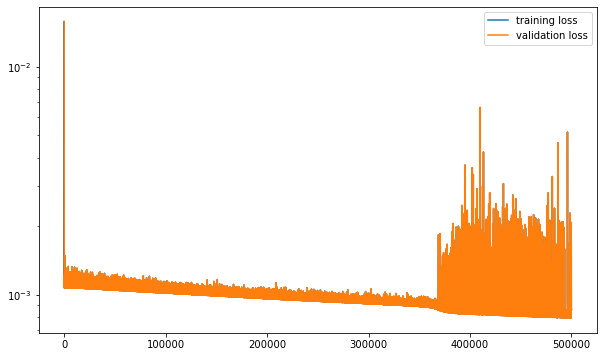

In [47]:
plt.figure(figsize=[10,6])
plt.semilogy(convergence[0],label='training loss') 
plt.semilogy(convergence[1], label = 'validation loss') 
plt.legend()

### Here we do some statistical analysis of the "compression"

In [48]:
test_output = model_predict(dnn_model,data_in_norm,cudaoption)

In [49]:
data_reconstructed = test_output.detach().numpy()

In [50]:
data_out_norm = data_out_norm.detach().numpy()

(350, 680)


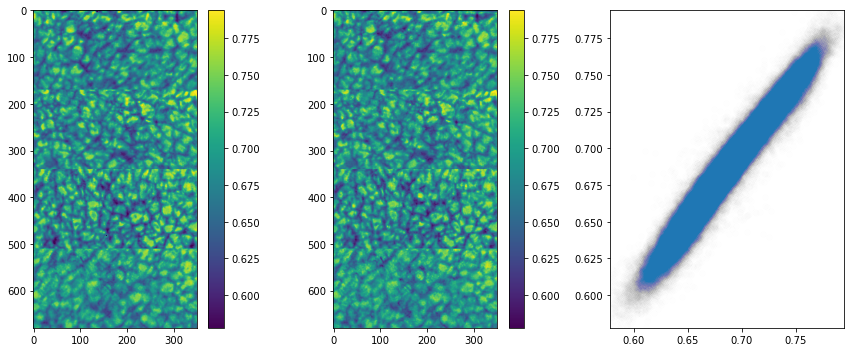

In [65]:
# Test some plots here:
i = 7
plt.figure(figsize=[12,5])
plt.subplot(131)
temp = data_out_norm.reshape(350,680,18)[:,:,i]
print(temp.shape)
v_min = np.mean(temp) - 3 * np.std(temp)
v_max = np.mean(temp) + 3 * np.std(temp)
plt.imshow(data_out_norm.reshape(350,680,18)[:,:,i].T,vmin=v_min,vmax=v_max)
plt.colorbar()
plt.subplot(132)
plt.imshow(data_reconstructed.reshape(350,680,18)[:,:,i].T, vmin=v_min,vmax=v_max)
plt.colorbar()
plt.subplot(133)
plt.scatter(data_out_norm.reshape(350,680,18)[:,:,i], data_reconstructed.reshape(350,680,18)[:,:,i],alpha=0.002)
plt.xlim([v_min,v_max])
plt.ylim([v_min,v_max])
plt.tight_layout()

In [66]:
print(np.std(data_out_norm.reshape(350,680,18)[:,:,i] - data_reconstructed.reshape(350,680,18)[:,:,i])*(max_t-min_t))

43.38898835486725


## de-normalize

data_reconstructed  = data_reconstructed * (dmax-dmin) + dmin

In [ ]:
noise = np.mean(data[:,0]) * 7E-3

residual = (data - data_reconstructed)
residual /= noise
residual = residual**2.0
print (len(residual))
chisq = np.sum(residual,axis=1) / 201
print (np.mean(chisq))
print (np.median(chisq))

In [ ]:
plt.figure(figsize=[10,7])
plt.hist(chisq,bins=50,range=[0,5])

In [ ]:
# Example plots 

i = 1652

plt.figure(figsize=[10,6])
plt.plot(data[i], label = 'Original')
plt.plot(data_reconstructed[i], label = 'Compressed')
plt.legend()

### Simple validation here:

In [ ]:
ae_model = torch.load('hinode_encoding_6.pt')

In [ ]:
data_val = fits.open("C:/Data/Hinode_ML_compression/qs_ph_disk_center_synth_1_1_hinodewvl.fits")[0].data

In [ ]:
data_val = data_val[:,:,0,:].reshape(768*768, 112)

In [ ]:
noise = np.mean(data_val[:,0]) * 7E-3
print (noise)

In [ ]:
data_val += np.random.normal(0,noise, (768*768, 112))

In [ ]:
data_val = (data_val - dmin) / (dmax-dmin)

In [ ]:
data_val = torch.from_numpy(data_val.astype('float32'))

In [ ]:
data_val_predicted = model_predict(ae_model,data_val, cudaoption)

In [ ]:
data_val_predicted = data_val_predicted.detach().numpy()
data_val = data_val.detach().numpy()

In [ ]:
data_val_predicted = data_val_predicted * (dmax-dmin) + dmin
data_val = data_val * (dmax-dmin) + dmin

In [ ]:


residual = (data_val - data_val_predicted)
residual /= noise
residual = residual**2.0
print (len(residual))
chisqval = np.sum(residual,axis=1) / 112
print (np.mean(chisqval))
print (np.median(chisqval))

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

In [ ]:
plt.figure(figsize=[10,7])
plt.hist(chisqval.flatten(),bins=50,range=[0,8])

In [ ]:
# Example plots 

llambda = np.linspace(0,111,112) - 56.5
llambda *= 0.0215 
llambda += 6302

i = 13156

plt.figure(figsize=[10,5])
plt.plot(llambda, data_val[i],label='original', lw=3)
plt.plot(llambda, data_val_predicted[i], label = 'prediction', lw=3)
plt.legend()
#plt.tight_layout()
plt.savefig('output.png', bbox_inches = 'tight')

In [ ]:
plt.figure(figsize=[10,5])
plt.plot(llambda, data_val[i],label='original', lw=3)
#plt.plot(llambda, data_val_predicted[i], label = 'prediction', lw=3)
#plt.tight_layout()
plt.savefig('input.png', bbox_inches = 'tight')

In [ ]:
data_val = torch.from_numpy(data_val.astype('float32'))
data_val_compressed = model_encode(ae_model,data_val, cudaoption)

In [ ]:
data_val_compressed = data_val_compressed.detach().numpy()

In [ ]:
data_val_compressed = data_val_compressed.reshape(768,768,6)


In [ ]:
atmos = fits.open("C:/Data/Hinode_ML_compression/qs_ph_disk_center_1_1_tau.fits")[0].data


In [ ]:
atmos = atmos.transpose(0,2,3,1)

In [ ]:
print (atmos[0,0,0])

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(3, 3, figsize=[17.5, 15.0])

axes = axes.flatten()

im = axes[0].imshow(atmos[1,:,:,15].T, origin='lower',cmap = 'magma')
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(atmos[1,:,:,25].T, origin='lower',cmap = 'magma',vmin=4500,vmax=7000)
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(atmos[5,:,:,15].T/ (1E5), origin='lower',cmap = 'bwr',vmin = -5, vmax= 5)
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im, cax=cax, orientation='vertical')


for i in range(3,9):
    
    im = axes[i].imshow(data_val_compressed[:,:,i-3].T, cmap = 'gray', origin = 'lower')
    
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes('right', size='10%', pad=0.1)

    fig.colorbar(im, cax=cax, orientation='vertical')
    
fig.savefig("plt2.png",bbox_inches='tight')

In [ ]:
del (data_val)
del(data_val_predicted)
del(data_val_compressed)

In [ ]:
from scipy.stats import pearsonr

params = [atmos[1,:,:,15], atmos[1,:,:,25], atmos[1,:,:,35], atmos[5,:,:,15], atmos[5,:,:,25], atmos[5,:,:,35]]
params = np.asarray(params)

corr_matrix = np.zeros([6,6])

for i in range(0,6):
    for j in range(0,6):
        
        corr_matrix[i,j], _ = pearsonr(params[i,:,:].flatten(), data_val_compressed[:,:,j].flatten())

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=[24.0,7.6])

axes = axes.flatten()

for i in range(0,6):
    
    im = axes[i].hist(data_val_compressed[:,:,i].flatten(),bins=100,range=(0,1))
    
    #divider = make_axes_locatable(axes[i])
    #cax = divider.append_axes('right', size='10%', pad=0.1)

    #fig.colorbar(im, cax=cax, orientation='vertical')

## Here we apply it to the Lites cube!

In [ ]:
obs_qs = fits.open("C:/Data/Hinode_ML_compression/lites_qs.fits")[0].data[:,:,0,:]

In [ ]:
plt.figure(figsize=[10, 14.34])
plt.imshow(obs_qs[:,:1434,5].T, origin = 'lower', cmap = 'gray')
plt.savefig("liteqs_background.png", bbox_inches = 'tight')

In [ ]:
obs_qs = obs_qs.astype('double')

In [ ]:
mean_qs = np.mean(obs_qs, axis=(0,1))

In [ ]:
obs_qs.shape

In [ ]:
plt.plot(obs_qs[0,0])

In [ ]:
plt.plot(mean_qs)

In [ ]:
qs_cont = np.mean(mean_qs[-10:])

In [ ]:
obs_qs[:,:,:] = obs_qs / qs_cont

In [ ]:
plt.plot(obs_qs[0,0])

In [ ]:
obs_qs = obs_qs.reshape(-1,112)

In [ ]:
obs_qs.shape

In [ ]:
obs_qs = (obs_qs - dmin) / (dmax-dmin)
obs_qs = torch.from_numpy(obs_qs.astype('float32'))
obs_qs_predicted = model_predict(ae_model,obs_qs, cudaoption)
obs_qs_predicted = obs_qs_predicted.detach().numpy()
obs_qs = obs_qs.detach().numpy()
obs_qs_predicted = obs_qs_predicted * (dmax-dmin) + dmin
obs_qs = obs_qs * (dmax-dmin) + dmin

residual = (obs_qs - obs_qs_predicted)
residual /= noise
residual = residual**2.0
print (len(residual))
chisq = np.sum(residual,axis=1) / 112
print (np.mean(chisq))
print (np.median(chisq))

In [ ]:
plt.figure(figsize=[10,7])
plt.hist(chisqval.flatten(),bins=50,range=[0,8],density = True, alpha=0.7, label = 'Simulated data')
plt.hist(chisq.flatten(),bins=50,range=[0,8],density = True, alpha=0.7, label = 'Observations')
plt.xlabel("Chi-squared")
plt.ylabel("%")
plt.legend()
plt.savefig("chisqcomp.png",bbox_inches = 'tight')

In [ ]:
obs_qs = torch.from_numpy(obs_qs.astype('float32'))


In [ ]:
obs_qs_compressed = model_encode(ae_model,obs_qs, cudaoption)
obs_qs_compressed = obs_qs_compressed.detach().numpy()
obs_qs_compressed = obs_qs_compressed.reshape(1024,2047,6)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(2, 3, figsize=[17.0,9])

axes = axes.flatten()

for i in range(0,6):
    
    im = axes[i].imshow(obs_qs_compressed[:512,:512,i].T, origin='lower', cmap='gray')
    
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes('right', size='10%', pad=0.1)

    fig.colorbar(im, cax=cax, orientation='vertical')
    
plt.savefig("obs_compression.png",bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=[24.0,7.6])

axes = axes.flatten()

for i in range(0,6):
    
    im = axes[i].hist(obs_qs_compressed[:,:,i].flatten(),bins=100,range=(0,1))
    
    #divider = make_axes_locatable(axes[i])
    #cax = divider.append_axes('right', size='10%', pad=0.1)

    #fig.colorbar(im, cax=cax, orientation='vertical')

In [ ]:
i = 86681

plt.figure(figsize=[10,6])
plt.plot(obs_qs[i],label='original')
plt.plot(obs_qs_predicted[i], label = 'compressed')
plt.legend()

## How does it compare with PCA?

In [ ]:
import numpy as np
from sklearn.decomposition import IncrementalPCA

ipca = IncrementalPCA(n_components=6, batch_size=512)
ipca.fit(data_val.reshape(-1,112))


In [ ]:
data_val_ipca = ipca.transform(data_val.reshape(-1,112))

In [ ]:
data_val_ipca.shape

In [ ]:
data_val_restored = ipca.inverse_transform(data_val_ipca)


In [ ]:
data_val = data_val.detach().numpy()

In [ ]:
residual = (data_val - data_val_restored)
residual /= noise
residual = residual**2.0
print (len(residual))
chisq = np.sum(residual,axis=1) / 112
print (np.mean(chisq))
print (np.median(chisq))

In [ ]:
data_val_ipca = data_val_ipca.reshape(768,768,6)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(2, 3, figsize=[17.5,9])

axes = axes.flatten()

for i in range(0,6):
    
    im = axes[i].imshow(data_val_ipca[:,:,i])
    
    divider = make_axes_locatable(axes[i])
    cax = divider.append_axes('right', size='10%', pad=0.1)

    fig.colorbar(im, cax=cax, orientation='vertical')